In [1]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import torch
import librosa
import IPython
import pandas as pd
import pickle
import torchaudio
import umap.umap_ as umap
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.is_available()

cuda:0


True

In [3]:
wav = "./data/Bird song/wavfiles/"

In [4]:
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size'] = 14

In [5]:
df = pd.read_csv("./data/Bird song/bird_songs_metadata.csv")
df

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5417,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-8.wav
5418,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-10.wav
5419,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-14.wav
5420,11713,Cardinalis,cardinalis,NaN,Northern Cardinal,Chris Parrish,United States,"Sewanee, Franklin County, Tennessee",35.2176,-85.9220,580,song,//www.xeno-canto.org/11713,//creativecommons.org/licenses/by-nc-nd/2.5/,06:21,2007-03-31,NaN,11713-15.wav


In [6]:
df = df[["id", "name", "filename"]]
df


,id,name,filename
0,557838,Bewick's Wren,557838-0.wav
1,557838,Bewick's Wren,557838-1.wav
2,557838,Bewick's Wren,557838-4.wav
3,557838,Bewick's Wren,557838-5.wav
4,557838,Bewick's Wren,557838-6.wav
...,...,...,...
5417,11713,Northern Cardinal,11713-8.wav
5418,11713,Northern Cardinal,11713-10.wav
5419,11713,Northern Cardinal,11713-14.wav
5420,11713,Northern Cardinal,11713-15.wav


<Axes: >

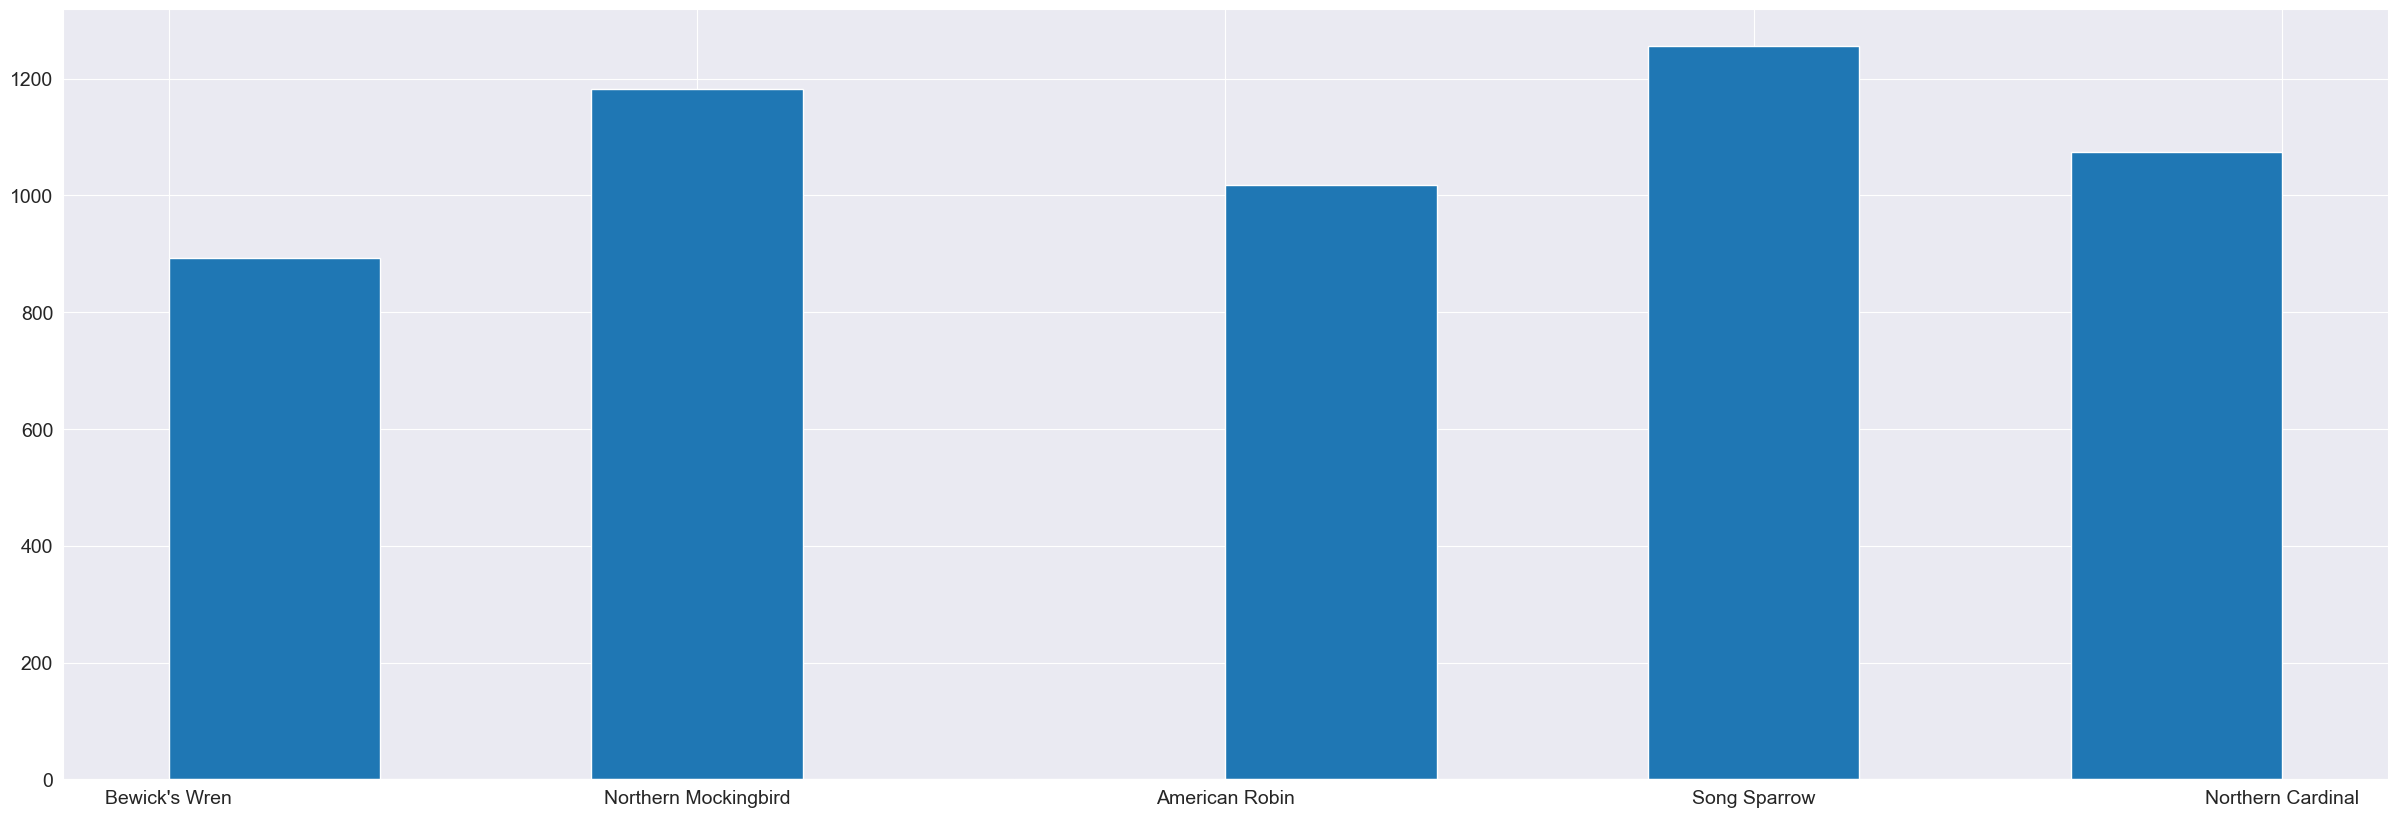

In [7]:
df["name"].hist()

In [8]:
sounds = []
for name in df["filename"]:
    sample, sr = librosa.load(wav + name)

    sample, _ = librosa.effects.trim(sample)
    sounds.append(torch.tensor(sample))

with open("sounds.txt", "wb") as sound_file:
    pickle.dump(sounds, sound_file)

In [9]:
sample, sr = librosa.load(wav + df["filename"][15])
sr

22050

In [10]:
with open("sounds.txt", "rb") as sound_file:
    birds_bytes = pickle.load(sound_file)

In [11]:
c = collections.Counter([t.size() for t in birds_bytes])
c

Counter({torch.Size([66150]): 5408,
         torch.Size([65638]): 2,
         torch.Size([63488]): 1,
         torch.Size([66048]): 3,
         torch.Size([65536]): 1,
         torch.Size([64614]): 1,
         torch.Size([60006]): 1,
         torch.Size([65126]): 1,
         torch.Size([61440]): 1,
         torch.Size([64512]): 1,
         torch.Size([63590]): 1,
         torch.Size([57958]): 1})

In [12]:
birds_names = list(set(df["name"]))
birds_names

['Northern Mockingbird',
 'Northern Cardinal',
 'American Robin',
 'Song Sparrow',
 "Bewick's Wren"]

In [13]:
dict(zip(set(df["name"]), range(len(set(df["name"])))))

{'Northern Mockingbird': 0,
 'Northern Cardinal': 1,
 'American Robin': 2,
 'Song Sparrow': 3,
 "Bewick's Wren": 4}

In [14]:
df["name_id"] = df["name"].map(dict(zip(set(df["name"]), range(len(set(df["name"]))))))

In [15]:
birds_bytes_reshape = list(map(lambda x: x.reshape(np.product(x.shape)), birds_bytes))
birds_bytes_length = list(map(len, birds_bytes_reshape))

In [16]:
df["tensor"] = birds_bytes_reshape

In [17]:
df["len"] = birds_bytes_length

In [18]:
df = df[df["len"] == 66150]

In [19]:
df = shuffle(df, random_state=42)

In [20]:
df.head()

,id,name,filename,name_id,tensor,len
4282,78060,Song Sparrow,78060-5.wav,3,"[tensor(-0.0975), tensor(-0.4167), tensor(-0.1...",66150
1622,319143,Northern Mockingbird,319143-0.wav,0,"[tensor(-0.0147), tensor(-0.0072), tensor(0.00...",66150
1931,54018,Northern Mockingbird,54018-14.wav,0,"[tensor(-0.0222), tensor(-0.0010), tensor(0.02...",66150
230,351083,Bewick's Wren,351083-12.wav,4,"[tensor(-0.0895), tensor(0.0491), tensor(0.191...",66150
466,217924,Bewick's Wren,217924-4.wav,4,"[tensor(0.1064), tensor(0.2445), tensor(-0.015...",66150


In [21]:
df.head()

,id,name,filename,name_id,tensor,len
4282,78060,Song Sparrow,78060-5.wav,3,"[tensor(-0.0975), tensor(-0.4167), tensor(-0.1...",66150
1622,319143,Northern Mockingbird,319143-0.wav,0,"[tensor(-0.0147), tensor(-0.0072), tensor(0.00...",66150
1931,54018,Northern Mockingbird,54018-14.wav,0,"[tensor(-0.0222), tensor(-0.0010), tensor(0.02...",66150
230,351083,Bewick's Wren,351083-12.wav,4,"[tensor(-0.0895), tensor(0.0491), tensor(0.191...",66150
466,217924,Bewick's Wren,217924-4.wav,4,"[tensor(0.1064), tensor(0.2445), tensor(-0.015...",66150


In [44]:
lfcc_transformer = torchaudio.transforms.LFCC(sample_rate=22050, n_filter=512, n_lfcc=256)
prep = []
for i in df["tensor"]:
    lfcc = lfcc_transformer(i)
    lfcc = lfcc.reshape(np.product(lfcc.shape))
    prep.append(lfcc.numpy())


In [45]:
prep[0].shape

(84736,)

In [46]:
df["prepared"] = prep

In [47]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(prep, df["name_id"])
print()

In [48]:
embs = umap.UMAP().fit_transform(prep)

In [49]:
def plot_scatter(embs, labels, pred):
    plt.subplot(1, 2, 1)
    plt.scatter(embs[:, 0], embs[:, 1], c=labels, s=50, edgecolors="k")
    plt.subplot(1, 2, 2)
    plt.scatter(embs[:, 0], embs[:, 1], c=pred, s=50, edgecolors="k")
    plt.show()

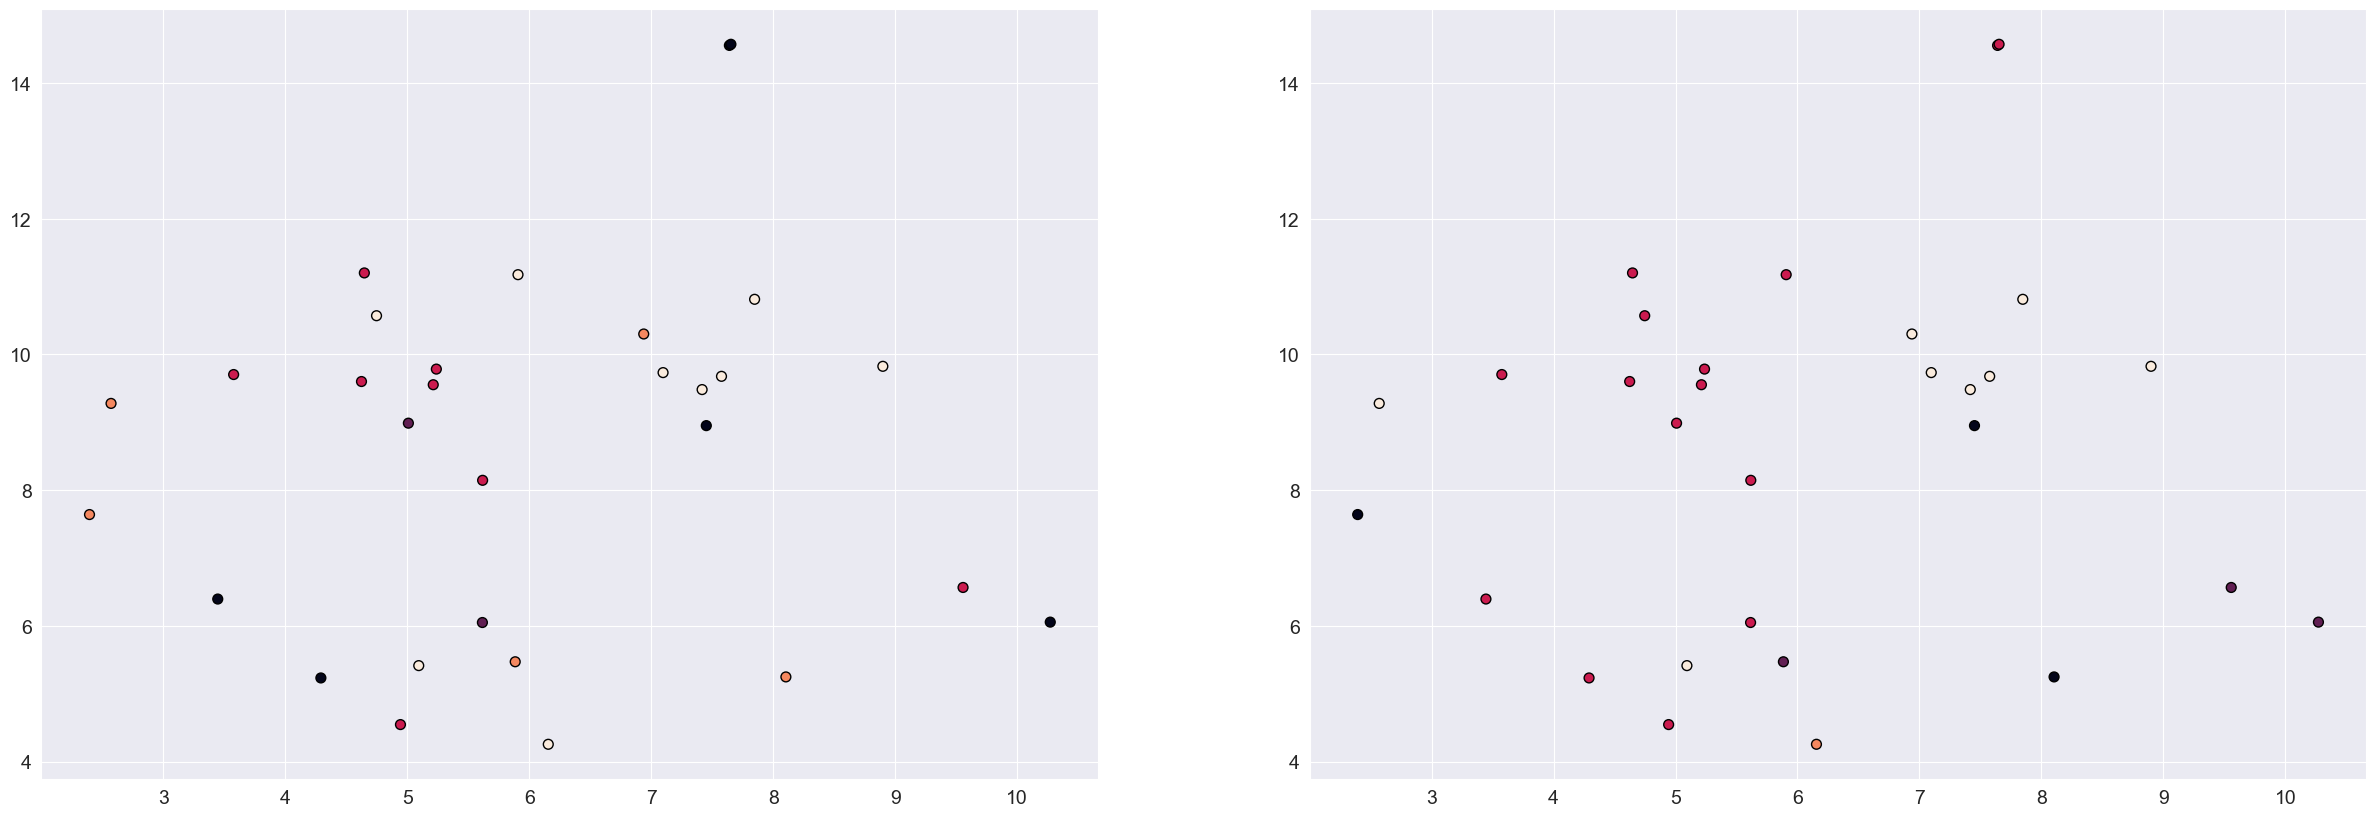

In [50]:
plot_scatter(embs[:30], df["name_id"][:30], knn.predict(prep[:30]))

In [51]:
pred = knn.predict(prep)

In [54]:
confusion_matrix(df["name_id"], pred)

array([[396,  55, 609,  35,  86],
       [ 79, 371, 493,  41,  88],
       [ 46,  34, 873,  15,  46],
       [ 63,  50, 180, 564, 397],
       [ 30,  23,  72, 110, 652]], dtype=int64)

In [55]:
ln = len(embs) // 10

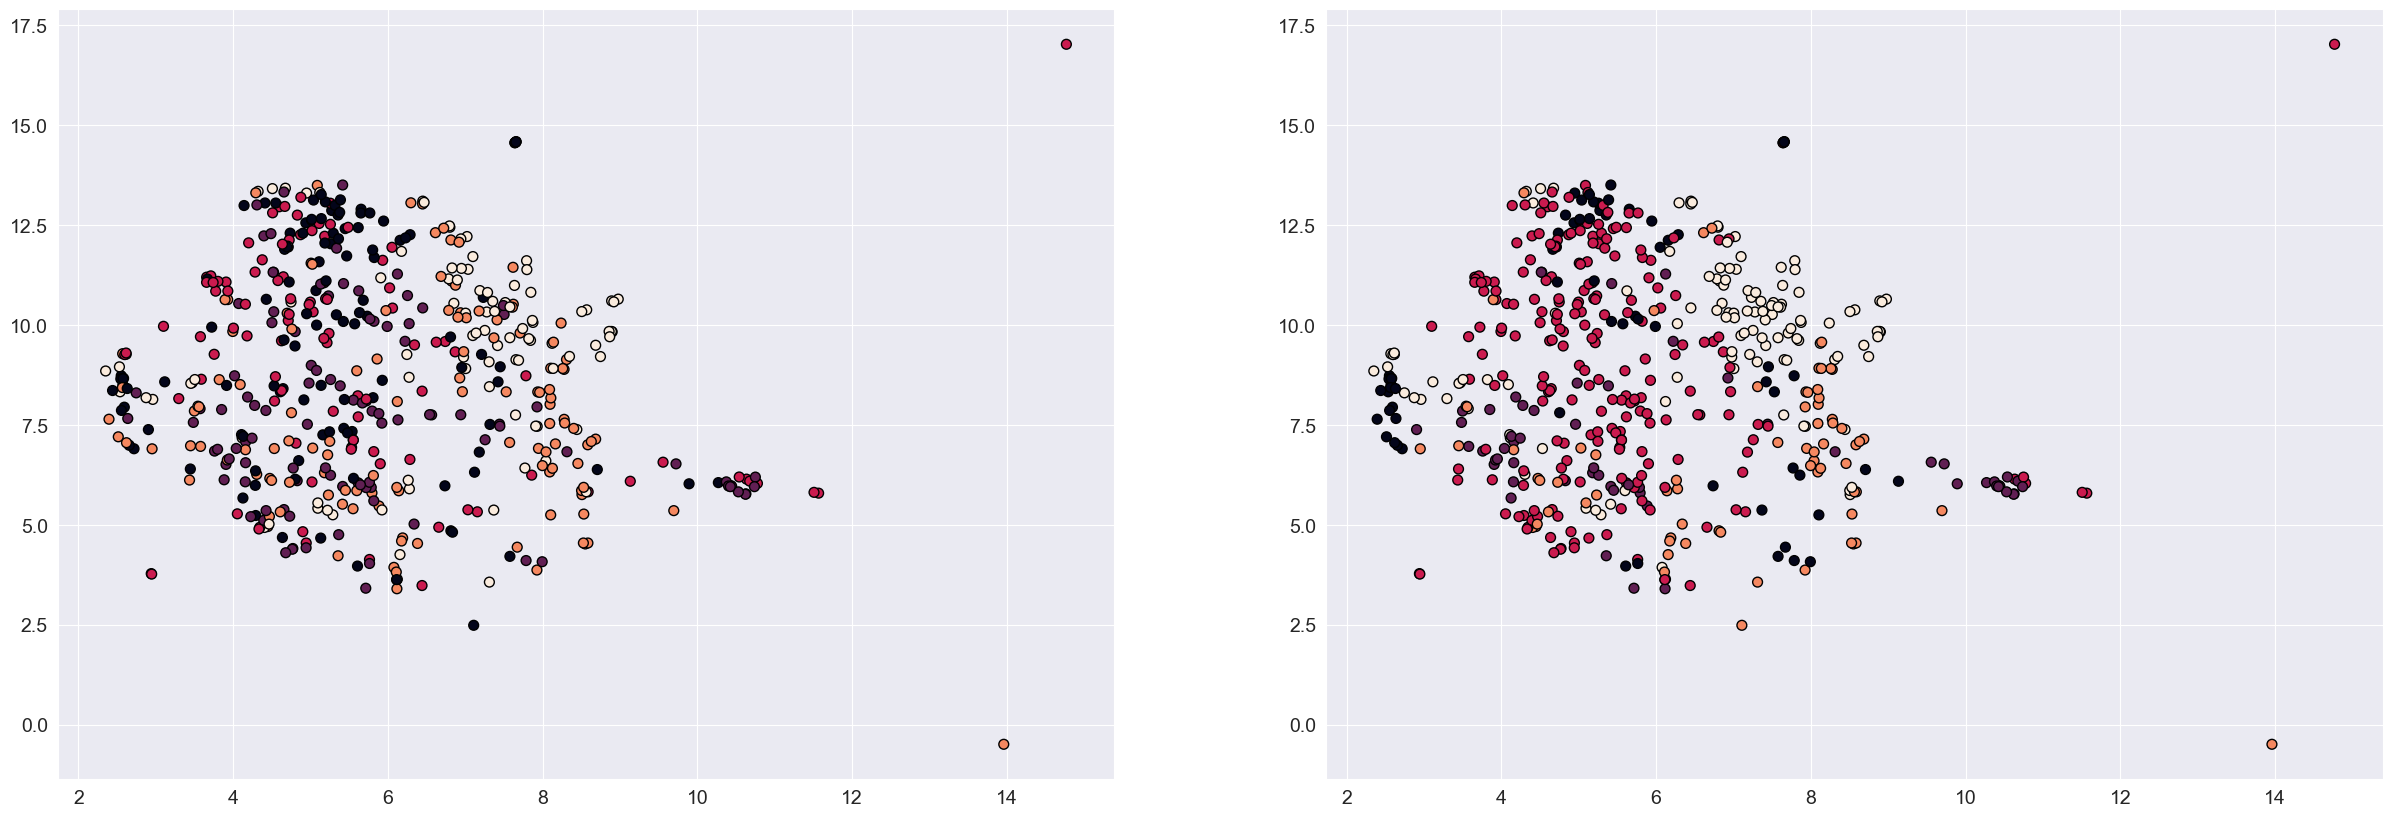

In [56]:
plot_scatter(embs[:ln], df["name_id"][:ln], pred[:ln])

In [66]:
df.head()

,id,name,filename,name_id,tensor,len,prepared,error
4282,78060,Song Sparrow,78060-5.wav,3,"[tensor(-0.0975), tensor(-0.4167), tensor(-0.1...",66150,"[-357.56, -711.31866, -789.5926, -818.2241, -8...",350.587646
1622,319143,Northern Mockingbird,319143-0.wav,0,"[tensor(-0.0147), tensor(-0.0072), tensor(0.00...",66150,"[-818.1926, -787.48486, -785.92975, -707.86316...",607.212769
1931,54018,Northern Mockingbird,54018-14.wav,0,"[tensor(-0.0222), tensor(-0.0010), tensor(0.02...",66150,"[-779.9844, -750.3706, -748.9557, -749.4126, -...",243.528000
230,351083,Bewick's Wren,351083-12.wav,4,"[tensor(-0.0895), tensor(0.0491), tensor(0.191...",66150,"[-542.2045, -680.48047, -699.0757, -674.04974,...",231.005646
466,217924,Bewick's Wren,217924-4.wav,4,"[tensor(0.1064), tensor(0.2445), tensor(-0.015...",66150,"[-415.8225, -730.43787, -693.97565, -672.64, -...",259.971893


In [83]:
ex = df.loc[1931]
ex

id                                                      54018
name                                     Northern Mockingbird
filename                                         54018-14.wav
name_id                                                     0
tensor      [tensor(-0.0222), tensor(-0.0010), tensor(0.02...
len                                                     66150
prepared    [-779.9844, -750.3706, -748.9557, -749.4126, -...
error                                              250.435989
Name: 1931, dtype: object

In [84]:
df["error"] = df.apply(lambda x: mean_squared_error(x["prepared"], ex["prepared"]), axis=1)

In [92]:
t = df.sort_values(by=["error"], ascending=True).head(5)
t

,id,name,filename,name_id,tensor,len,prepared,error
1931,54018,Northern Mockingbird,54018-14.wav,0,"[tensor(-0.0222), tensor(-0.0010), tensor(0.02...",66150,"[-779.9844, -750.3706, -748.9557, -749.4126, -...",0.000000
1929,54018,Northern Mockingbird,54018-12.wav,0,"[tensor(0.0004), tensor(-0.0060), tensor(-0.00...",66150,"[-732.81915, -703.8356, -710.8875, -693.6978, ...",108.713577
1932,54018,Northern Mockingbird,54018-15.wav,0,"[tensor(0.0094), tensor(0.0238), tensor(0.0257...",66150,"[-759.80524, -712.31067, -741.5375, -736.7853,...",112.396599
1923,54018,Northern Mockingbird,54018-6.wav,0,"[tensor(0.0058), tensor(-0.0088), tensor(-0.00...",66150,"[-776.4491, -761.4533, -743.16003, -740.8852, ...",113.921097
1924,54018,Northern Mockingbird,54018-7.wav,0,"[tensor(0.0043), tensor(-0.0194), tensor(-0.03...",66150,"[-730.971, -771.81885, -758.56775, -743.3572, ...",115.460808


In [93]:
t

,id,name,filename,name_id,tensor,len,prepared,error
1931,54018,Northern Mockingbird,54018-14.wav,0,"[tensor(-0.0222), tensor(-0.0010), tensor(0.02...",66150,"[-779.9844, -750.3706, -748.9557, -749.4126, -...",0.000000
1929,54018,Northern Mockingbird,54018-12.wav,0,"[tensor(0.0004), tensor(-0.0060), tensor(-0.00...",66150,"[-732.81915, -703.8356, -710.8875, -693.6978, ...",108.713577
1932,54018,Northern Mockingbird,54018-15.wav,0,"[tensor(0.0094), tensor(0.0238), tensor(0.0257...",66150,"[-759.80524, -712.31067, -741.5375, -736.7853,...",112.396599
1923,54018,Northern Mockingbird,54018-6.wav,0,"[tensor(0.0058), tensor(-0.0088), tensor(-0.00...",66150,"[-776.4491, -761.4533, -743.16003, -740.8852, ...",113.921097
1924,54018,Northern Mockingbird,54018-7.wav,0,"[tensor(0.0043), tensor(-0.0194), tensor(-0.03...",66150,"[-730.971, -771.81885, -758.56775, -743.3572, ...",115.460808


In [94]:
l = []
for i in t["filename"]:
    l.append(i)

In [95]:
IPython.display.Audio(wav + l[0])


In [96]:
IPython.display.Audio(wav + l[1])

In [97]:
IPython.display.Audio(wav + l[2])

In [98]:
IPython.display.Audio(wav + l[3])

In [100]:
IPython.display.Audio(wav + l[4])

In [99]:
l

['54018-14.wav', '54018-12.wav', '54018-15.wav', '54018-6.wav', '54018-7.wav']

In [103]:
import shutil

for i in l:
    shutil.copy(wav + i, "./tmp")